# Stand-alone driver of `bootstrap` in `stats.mod.py`

In [1]:
import numpy as np
from numpy import linalg as la
from collections import namedtuple

import matplotlib.pyplot as plt
from LIM_AM_mod import Myla, LIM_core, LIM, rand_model, rand_model2, rand_model_test
from get_AM_mod import JRA55, CMIP6, ERA5, NAM, SAM, get_y
from stats_mod import stats_tests_normal, stats_tests_rand_model, bootstrap, bootstrap_model, StackArray, get_ci_of_mean, get_ci_of_std, percentile_ci, basic_ci, bca_ci

# rand_model_test()

In [2]:
# stats_tests_normal(N = 40, mu = 1.12, sigma = 2.57)

# stats_tests_rand_model()

In [3]:
# plev = [850.,  700.,  500.,  250.,  100.,   50.,   10.]
# data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, source_dir='cmip6')
D, p, y, t, y2 = get_y(data, 'NAM')


Calculating from the original data .......
ERA5 (65, 365, 37) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 37), y2.shape = (64, 230, 37)


In [4]:
# from scipy import linalg as sla

# Q = np.array([[0.3, 0], [0, 0.1]])    # Q should be symmetric
# B = np.array([[-0.05, 0], [0, -0.1]])
# # B = np.array([[-0.05, -0.08], [0, -0.1]])

# # Q = np.array([[0.3, 0, 0], [0, 0.08, 0], [0, 0, 0.1]])    # Q should be symmetric
# # B = np.array([[-0.05, 0, 0], [0, -0.04, 0], [0, 0, -0.1]])
# # B = np.array([[-0.05, 0, 0], [-0.07, -0.04, 0], [0, 0, -0.1]])

# # Q =  - B @ C0 - C0 @ B.T
# C0 = -sla.solve_continuous_lyapunov(B, Q)
# b, _, _ = Myla.eig(B)

# y3 = rand_model2(B, Q, len_day=64*150, dt=0.2)
# y = np.reshape(y3, (64, 150, -1))
# print(f'\ny3={y3.shape}   y={y.shape}')

# print(f'B={B},\n Q={Q},\n C0={C0},\n eigenvalues of B: {b}')

# # get_ci_of_mean(y3)
# # get_ci_of_std(y3)

## Parameters

In [5]:
hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = 5,    # use 4 SVDs
                            eig_method = 'pinv',
                            ord   = 2,
                            )
                )
    # print(f'hyperpamameters:\n{hyp_param}')
    
model = LIM(y, hyp_param, verbose=False)


In [6]:
def plot_ci(Stack_LIM, ci_stacked, dis_stacked, se_stacked):
    ci = (Stack_LIM.unstack(ci_stacked[0], 'low'), Stack_LIM.unstack(ci_stacked[1], 'high'))
    dis = Stack_LIM.unstack(dis_stacked, 'distribution', axis=1)
    se = Stack_LIM.unstack(se_stacked, 'standard_error')

    for name in Stack_LIM.shapes:
        print(f"95% CI of {name}: low={getattr(ci[0], name)},\nhigh={getattr(ci[1], name)}\n")

    N = len(model.b)
    # plt.plot(range(N), 1/b.real, color='red', label='True')
    # plt.plot(range(N), 1/model.b.real, color='blue', label='Mean')
    # plt.fill_between(range(N), np.squeeze(1/ci[0].b), np.squeeze(1/ci[1].b), color='blue', alpha=0.2, label='95% CI')
    plt.errorbar(range(N), -1/model.b.real, [-1/model.b.real+np.squeeze(1/ci[0].b.real), -np.squeeze(1/ci[1].b.real)+1/model.b.real], fmt='o', color='blue', label='95% CI')
    plt.legend()
    plt.show()

## Non-parametric bootstrap

95% CI of b: low=[-0.04712335 -0.04728105 -0.09349385 -0.14633181 -0.24927673],
high=[-0.03165121 -0.03161104 -0.05476418 -0.11032674 -0.19478606]



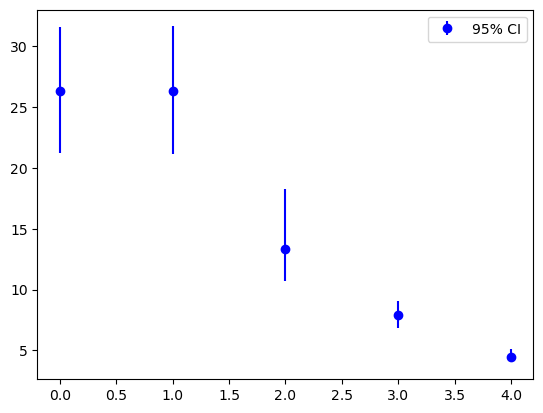

In [7]:
Stack_LIM = StackArray()

def stat_func(y, axis):
    model = LIM(y, hyp_param, verbose=False)
    Stack_LIM.add_array('b', model.b.real)
    # Stack_LIM.add_array('y', y)
    return Stack_LIM.stack()

ci_stacked, dis_stacked, se_stacked = bootstrap(y, statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='BCa')

plot_ci(Stack_LIM, ci_stacked, dis_stacked, se_stacked)

## Parameteric bootstrap with `boot_model`

95% CI of b: low=[-0.04661256 -0.04670556 -0.08808941 -0.1405087  -0.24162045],
high=[-0.03187476 -0.03187476 -0.05408413 -0.11073633 -0.19129002]



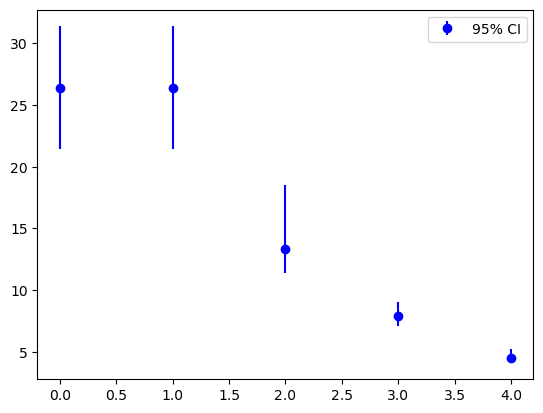

In [8]:
Stack_LIM = StackArray()

def stat_func(y, axis):
    model = LIM(y, hyp_param, verbose=False)
    Stack_LIM.add_array('b', model.b.real)
    # Stack_LIM.add_array('y', y)
    return Stack_LIM.stack()

class boot_model():
    def __init__(self, data):
        self.model = LIM(data, hyp_param)
        self.spinup = 100
        self.len_year, self.len_days, _ = data.shape
        
    def get_sample(self, random_state):
        boot_data = rand_model(self.model.B_r, self.model.vr_Q, self.model.w_Q, len_day=self.len_year*self.len_days+self.spinup, dt=0.2, verbose=False, get_x_from_r=None, random_state=random_state)
        return boot_data[self.spinup:].reshape((self.len_year, self.len_days, -1))

ci_stacked, dis_stacked, se_stacked = bootstrap_model(y, boot_model, statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='BCa')

plot_ci(Stack_LIM, ci_stacked, dis_stacked, se_stacked)